## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)


<a id='intro'></a>
### Introduction

For this project, I will be analyzing the results of an A/B test run by an e-commerce website.  The goal is to understand if the company should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#Setting the seed to assure you get the same answers
random.seed(42)

Reading in the `ab_data.csv` data. Stored in `df`.

In [3]:
df = pd.read_csv("ab_data.csv")
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


Finding the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

Showing the number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

Showing the proportion of users converted.

In [6]:
df['converted'].mean()

0.11965919355605512

Showing the number of times the `new_page` and `treatment` don't line up.

In [7]:
df_treatment = df.query('group == "treatment"')
df_treatment_bad = df_treatment.query('landing_page != "new_page"')
df_treatment.query('landing_page != "new_page"').count()

user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64

In [8]:
df_control = df.query('group == "control"')
df_control_bad = df_control.query('landing_page != "old_page"')
df_control.query('landing_page != "old_page"').count()

user_id         1928
timestamp       1928
group           1928
landing_page    1928
converted       1928
dtype: int64

Checking for any rows with missing values

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page, so we will drop it.

Stored new new dataframe in **df2**.

In [10]:
df.drop(df_control_bad.index,inplace=True)

In [11]:
df.drop(df_treatment_bad.index,inplace=True)

In [12]:
df2 = df.copy()

In [13]:
# Double checking all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Showing how many unique **user_id**s are in **df2**

In [14]:
df2['user_id'].nunique()

290584

Checking for repeat **user_id**

In [15]:
df_repeat = df2.loc[df2['user_id'].duplicated(),:]
df_repeat

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing **one** of the rows with a duplicate **user_id**.

In [17]:
df2.drop(df_repeat.index,inplace=True)

In [18]:
df2.duplicated().sum()

0

Finding the probability of an individual converting regardless of the page they receive

In [19]:
df2['converted'].mean()

0.11959708724499628

Finding the probability they converted given that an individual was in the `control` group

In [20]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

Finding the probability they converted given that an individual was in the `treatment` group

In [21]:
df2.query('group =="treatment"')['converted'].mean()

0.11880806551510564

Finding the probability that an individual received the new page

In [22]:
df2.query('landing_page == "new_page"').count()[0]/df2.shape[0]

0.50006194422266881

**Given that the size of each group is about 50-50 control-treatment, the groups are fairly represented. The conversion rate for the control group is 12.04% while the rate for the treatment group is 11.88%. Even though the control group appears to have a higher conversion rate, the difference is not practically significant and therefore does not indicate to me that one leads to more conversions over the other.**

<a id='ab_test'></a>
### Part II - A/B Test 


Assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, see the null and alternative hypotheses below. **$p_{old}$** and **$p_{new}$** are the converted rates for the old and new pages.

**$H_{0}$** : **$p_{new}$** - **$p_{old}$** ≤ 0

**$H_{1}$** : **$p_{new}$** - **$p_{old}$** > 0

Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Showing the **convert rate** for $p_{new}$ under the null

In [23]:
pnew = df2['converted'].mean()
pnew

0.11959708724499628

Showing the **convert rate** for $p_{old}$ under the null

In [24]:
pold = df2['converted'].mean()
pold

0.11959708724499628

Showing $n_{new}$

In [25]:
nnew = df2.query('landing_page == "new_page"').shape[0]
nnew

145310

Showing $n_{old}$

In [26]:
nold = df2.query('landing_page == "old_page"').shape[0]
nold

145274

Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = df2.sample(nnew,replace=True)

Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = df2.sample(nold,replace=True)

Finding $p_{new}$ - $p_{old}$ for simulated values from part (e) and (f).

In [30]:
diff = new_page_converted['converted'].mean() - old_page_converted['converted'].mean()
diff

-0.00049082318204154984

Simulating 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one calculated above.  Storing all 10,000 values in **p_diffs**.

In [154]:
p_diffs = []
for _ in range(10000):
    new_page_converted = df2.sample(nnew,replace=True)['converted'].mean()
    old_page_converted = df2.sample(nold,replace=True)['converted'].mean()
    p_diffs.append(new_page_converted - old_page_converted)

Plotting a histogram of the **p_diffs**.

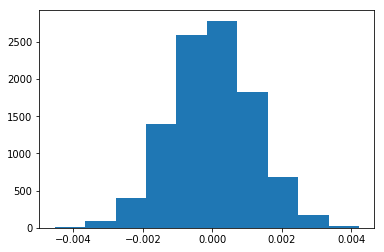

In [155]:
plt.hist(p_diffs);

Finding proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**

In [170]:
p_diffs = np.array(p_diffs)
(np.random.normal(0,p_diffs.std(),p_diffs.size) > diff).mean()

0.84599999999999997

**This is the p value. The p value tells us the proportion of values in the null distribution that are greater than the observed difference. The p value tells us whether we can reject or fail to reject the null hypothesis. A p value of 0.85 is very high, which tells us that it is likely our value came from the null hypothesis, meaning we cannot reject it. This means that it likely that there is no difference between the new and old landing pages.**

We could also use a built-in methods to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. See below for the calculations of the number of conversions for each page, as well as the number of individuals who received each page. `n_old` and `n_new` refer to the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].mean()
convert_new = df2.query('landing_page == "new_page"')['converted'].mean()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Using `stats.proportions_ztest` to compute the test statistic and p-value.

In [33]:
conv_old = df2.query('landing_page == "old_page"')['converted'].sum()
conv_old_total = df2.query('landing_page == "old_page"').shape[0]
conv_new = df2.query('landing_page == "new_page"')['converted'].sum()
conv_new_total = df2.query('landing_page == "new_page"').shape[0]
conv_old, conv_old_total, conv_new, conv_new_total

(17489, 145274, 17264, 145310)

In [36]:
z_score, p_value = sm.stats.proportions_ztest([conv_old, conv_new], [conv_old_total, conv_new_total], alternative = "larger")
z_score, p_value

(1.3109241984234394, 0.094941687240975514)

**This z score and p value confirm the findings from the previous section: that it is likely that our statistic came from the null, therefore we cannot reject the null hypothesis, and it is likely there is no significant difference between the new and old landing pages.**

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result acheived in the previous A/B test can also be acheived by performing regression.<br><br>

**Because the outcomes are binary (either 1 or 0), logistic regression is the appropriate method to use.**

The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Adding an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2['intercept'] = 1
df2[['new','old']] = pd.get_dummies(df2['landing_page'])
df2['ab_page'] = np.where(df2['group']=="treatment", 1, 0)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new,old,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


Using **statsmodels** to import the regression model.  Instantiating the model, and fitting the model using the two columns created above to predict whether or not an individual converts.

In [38]:
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Showing a summary of the model below

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Nov 2018   Pseudo R-squ.:               8.077e-06
Time:                        23:39:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**The p value associated with ab_page is 0.19, which is different than the 0.85 p value we calculated in Part II, however it is still large enough that we cannot reject the null hypothesis, meaning it is likely there is no difference in the new page versus the old page. The difference in p values is due to the difference in the type of hypothesis. The regression table shows are two-sided confidence interval while the p value from part II was a one-sided test.**

**There are many other factors that could influence whether an individual converts such as Change Aversion (existing users may give an unfair advantage to the old version simply becasue they don't like change) and Novelty Effect (existing users may give an unfair advantage to the new version because they are excited for the change). Both of the effects do not determine that one is better than the other; they are simply biases that can affect the accuracy of the model. This is why it is important to consider other factors.**

Now along with testing if the conversion rate changes for different pages, also seeing if there's an effect based on which country a user lives. Read in the **countries.csv** dataset and merging together the datasets on the approporiate rows.

In [40]:
country_df = pd.read_csv("countries.csv")
country_df.head(3)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK


In [41]:
df3 = df2.join(country_df.set_index('user_id'), on='user_id')
df3.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,new,old,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US


In [43]:
df3.groupby('country').count()

,user_id,timestamp,group,landing_page,converted,intercept,new,old,ab_page
country,,,,,,,,,
CA,14499,14499,14499,14499,14499,14499,14499,14499,14499
UK,72466,72466,72466,72466,72466,72466,72466,72466,72466
US,203619,203619,203619,203619,203619,203619,203619,203619,203619


In [44]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new,old,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1


In [49]:
logit_mod = sm.Logit(df3['converted'],df3[['intercept','ab_page','CA','UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 15 Nov 2018   Pseudo R-squ.:               2.323e-05
Time:                        23:43:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**The p values for the countries also appear to be high, meaning that we cannot conclude whether they have a significant effect on conversion.**

Though we have now looked at the individual factors of country and page on conversion, we would like to look at an interaction between page and country to see if there significant effects on conversion.  Creating the necessary additional columns, and fitting the new model.

In [47]:
df3['US_ind_ab_page'] = df3['US']*df3['ab_page']
df3['CA_ind_ab_page'] = df3['CA']*df3['ab_page']
logit_h = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'CA', 'US_ind_ab_page', 'CA_ind_ab_page']])

In [48]:
results_h = logit_h.fit()
results_h.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 15 Nov 2018   Pseudo R-squ.:               3.482e-05
Time:                        23:42:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page            0.0108      0.023      0.475      0.635      -0.034       0.056
US                 0.0057      0.019      0.306      0.760      -0.031       0.043
CA                -0.0118      0.040     -0.296      0.767      -0.090       0.066
US_ind_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA_ind_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
==================================================================================
"""

**Again there does not appear to be a significant effect of the interaction between ab_page and country and conversion.**

<a id='conclusions'></a>


## Conclusions

> This project entailed analyzing A/B Testing using various methods to ideally reach the same conclusion. The process started by looking at simple conversion rates which showed that although there was a slightly higher conversion rate from the new page of 12.04% versus 11.88% from the old page, I do not believe this difference was practically significant.

> The process continued by using hypothesis testing to analyze the null and alternative hypotheses using the bootstrapping technique. This method concluded that the conversions from the new and old landing pages was not significant enough to show a material difference.

> Additionally, we identified that there could be external factors contributing to these results such as the Change Aversion and Novelty Effect biases. 

> Finally, we concluded the project by looking at logistic regression, which also showed that the results were not significant enough to determine a difference in conversions for the old and new page. 

In [50]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0